<a href="https://colab.research.google.com/github/UMassIonTrappers/quantum-computing-labs/blob/main/Lab_10_QFT_QPE_and_RSA_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

---

### Textbook
>Quantum Computation and Quantum Information , Authors:	Michael A. Nielsen, Isaac L. Chuang


## Supporting Materials Quantum Computation:


* https://www.scottaaronson.com/qclec.pdf

* http://theory.caltech.edu/~preskill/ph219/chap6_20_6A.pdf


#Qiskit

IBM's Quantum Information Software Kit

In [1]:
try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

Qiskit Aer imported


# Initialize

In [4]:
# %matplotlib inline

from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#Qisket imports
from qiskit_aer import QasmSimulator

from qiskit import QuantumCircuit, transpile
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector, plot_histogram
# from qiskit import *

# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.ibmq import least_busy
# from qiskit.providers.basicaer import BasicAer
# from qiskit.providers.aer.noise import *

from qiskit.circuit.library import *
from qiskit.circuit.library import GroverOperator
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector

'''
In Jupyter Notebooks we can display this nicely using Latex.
'''
from qiskit.visualization import array_to_latex
from qiskit.visualization import plot_bloch_multivector, plot_histogram

"""
Show ALL outputs, not just last expression
"""
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


'\nShow ALL outputs, not just last expression\n'

# Quantum Fourier Transform

The quantum Fourier transform (QFT) transforms between two bases, the computational (Z) basis, and the Fourier basis. The H-gate is the single-qubit QFT, and it transforms between the Z-basis states |0⟩ and |1⟩  to the X-basis states  |+⟩ and  |−⟩

In the same way, all multi-qubit states in the computational basis have corresponding states in the Fourier basis. The QFT is simply the function that transforms between these bases.

Another way to understand the fourier basis for qubits is to 'see' it count.

Follow this link to watch qubits count in the Z basis and the X basis (fourier basis):

https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#2.1-Counting-in-the-Fourier-basis:-

If you're still curious about the classical fourier transform this video goes through it in great detail:
* https://www.youtube.com/watch?v=spUNpyF58BY&ab_channel=3Blue1Brown

One important thing to note as you watch is that the rotation shown in the video described by $e^{iϕ}$ can very easily be seen as phase and that is exactly what we're going to do.

![Fourier Transform](https://i.imgur.com/c4UKxoA.png)

> https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

# Phase space

We have been encoding binary numbers in the state of the qubit along the Z basis. However, this basis is limited in that the state is either 0 or 1.

We know that the phase of the qubit has the ability to be arbitrarily rotated about the Z axis with phase gates. So far we have restricted our encoding to just the |+⟩ state and |-⟩ state along the X basis, which we have gotten to by using the Hadamard gate.

Next we will try to continuously use the phase degree of freedom to encode information.

For instance to encode the number 1 in phase using 3 qubits we would run the following circuit:

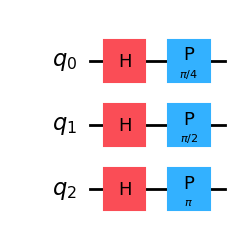

In [9]:
number = 1

nqubits = 3
qc = QuantumCircuit(nqubits)

qc.h(0)
qc.h(1)
qc.h(2)

qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi/1,2)

qc.draw('mpl')

We can add more precision by adding more qubits to the register.

Notice how the rotation angle of the final phase encoding gets finer and finer.

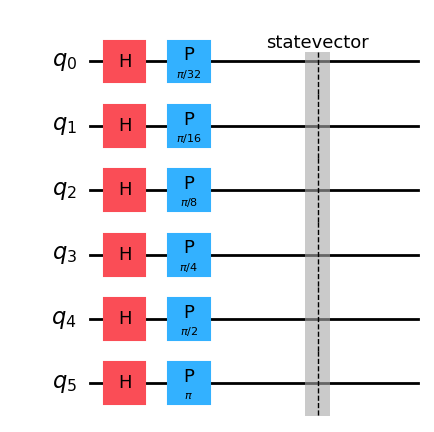

In [10]:
number = 1

nqubits = 6
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)

for qubit in range(nqubits):
    qc.p(number*pi/2**(nqubits-1-qubit),qubit)

qc.save_statevector()

qc.draw('mpl')

1


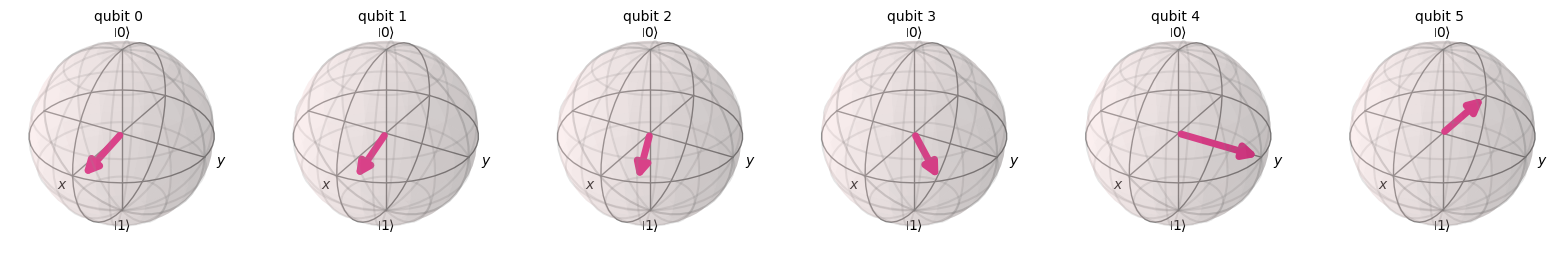

In [11]:
'''#Simulate'''
QasmSim = QasmSimulator() #Set simulator to evolve state
job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
result_sim = job_sim.result()

'''# Get the statevector from result'''
statevector = result_sim.get_statevector(qc)

print(number)
plot_bloch_multivector(statevector)

Encoding the number 2 in phase doubles the phase rotation of each bit, returning our last qubit, qubit 5, to its original |+⟩ state.

2


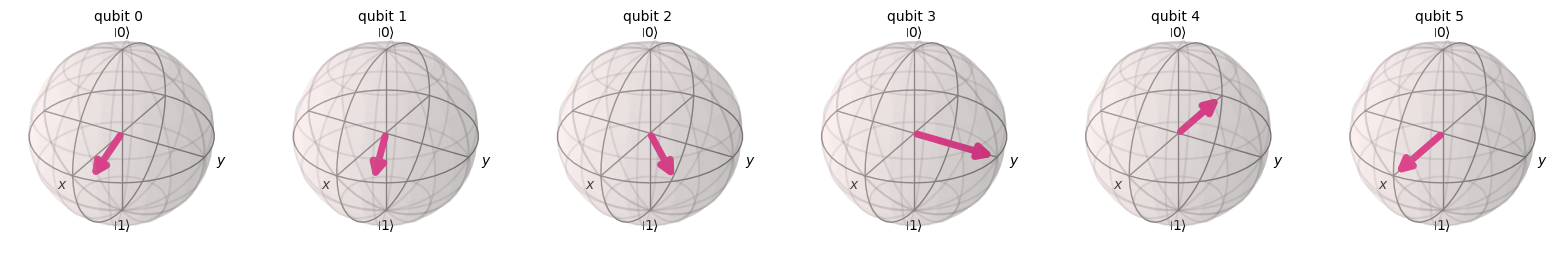

In [12]:
number = 2

nqubits = 6
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)

for qubit in range(nqubits):
    qc.p(number*pi/2**(nqubits-1-qubit),qubit)

qc.save_statevector()

job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
statevector = job_sim.result().get_statevector(qc)

# print(statevector)
print(number)
plot_bloch_multivector(statevector)

Now that we have setup a state in the phase basis we can use the Quantum Fourier Transform to bring it back to the counting basis.

# QFT functions

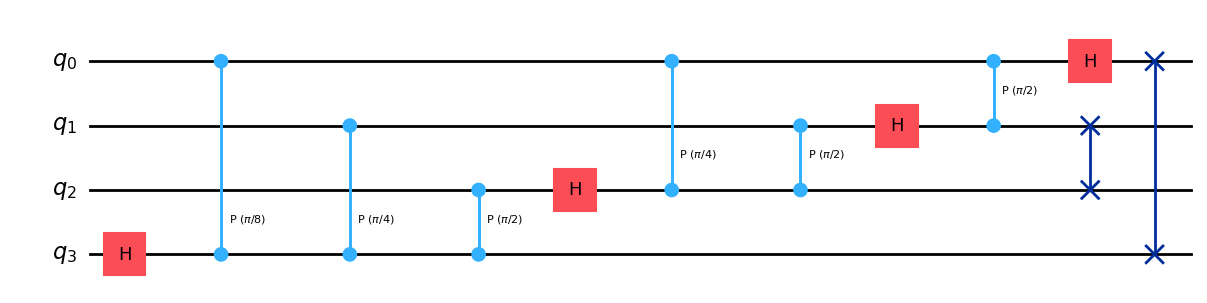

In [13]:
def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

nqubits = 4

#Create blank circuit
qc = QuantumCircuit(nqubits)

qft(qc,nqubits) # Add the QFT

qc.draw('mpl')

To do this we will actually need the Inverse QFT.
We can use the .inverse() method to invert the circuit.


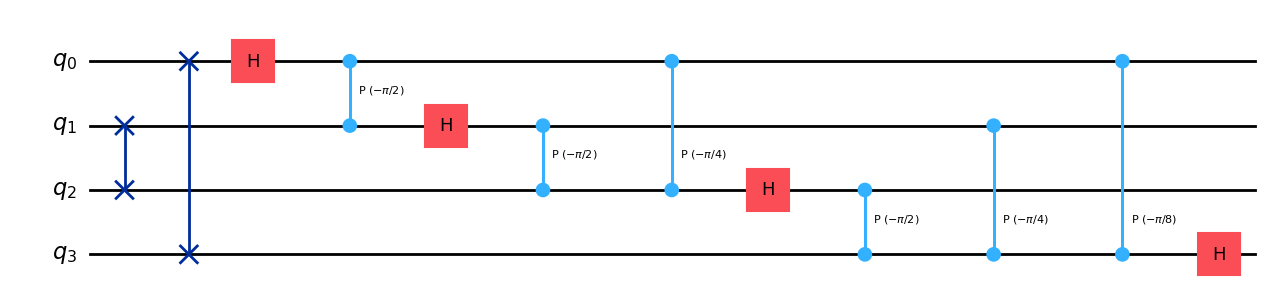

In [ ]:
# Inverse QFT
def inverse_qft(circuit, n):
    qft_circ = qft(QuantumCircuit(n,name='Inv_QFT'), n)
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit

#Blank Circuit
inverse_qc = QuantumCircuit(nqubits)

inverse_qft(inverse_qc,nqubits) #Add inverse QFT

inverse_qc = inverse_qc.decompose()

inverse_qc.draw('mpl')

In [ ]:
def qft_dagger(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

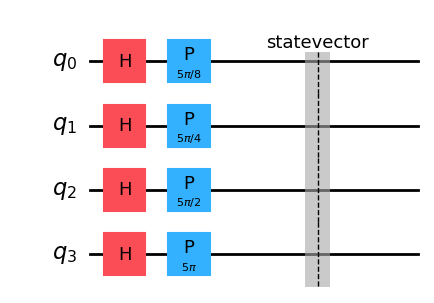

In [ ]:
number = 5

qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)

for qubit in range(nqubits):
    qc.p(number*pi/2**(nqubits-1-qubit),qubit)

qc.save_statevector()

qc.draw('mpl')

5


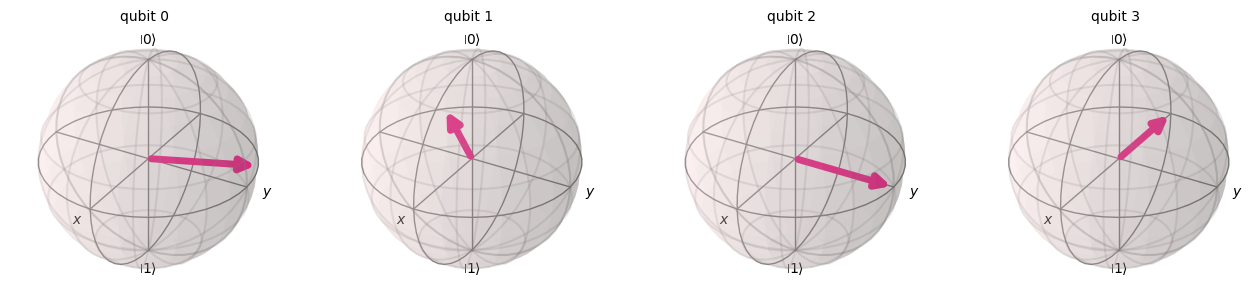

In [ ]:
#Simulate
job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
statevector = job_sim.result().get_statevector(qc)

# print(statevector)
print(number)
plot_bloch_multivector(statevector)

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

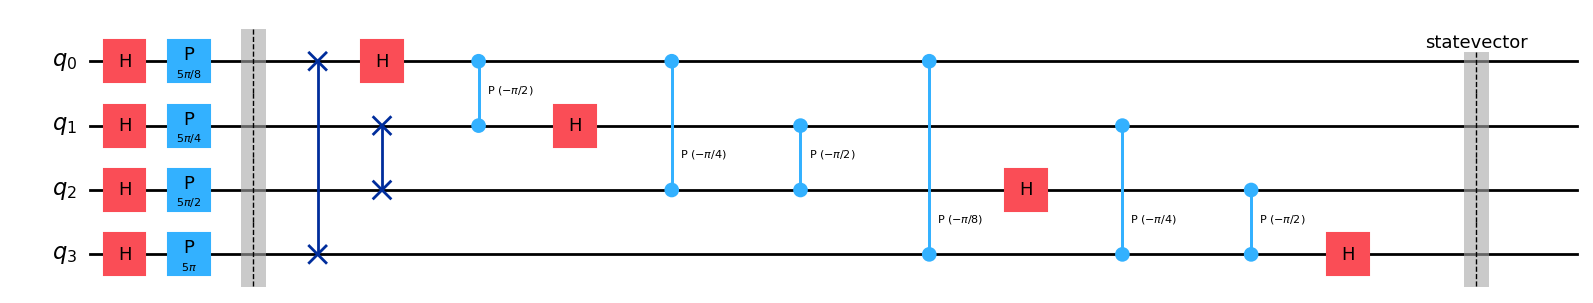

In [ ]:
number = 5

qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)

for qubit in range(nqubits):
    qc.p(number*pi/2**(nqubits-1-qubit),qubit)

qc.barrier()

qft_dagger(qc,nqubits)

qc.save_statevector()
# qc.measure_all()

qc.draw('mpl')

5


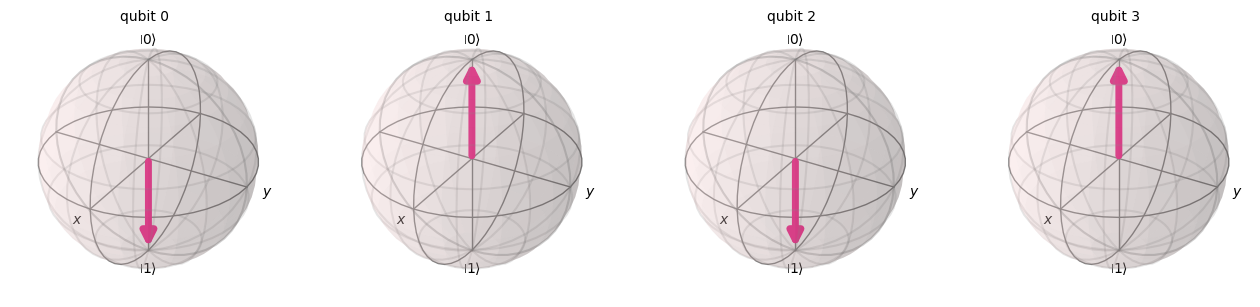

In [ ]:
#Simulate
job_sim = QasmSim.run(qc, shots=1) #run one shot for statevector
statevector = job_sim.result().get_statevector(qc)

print(number)
plot_bloch_multivector(statevector)

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

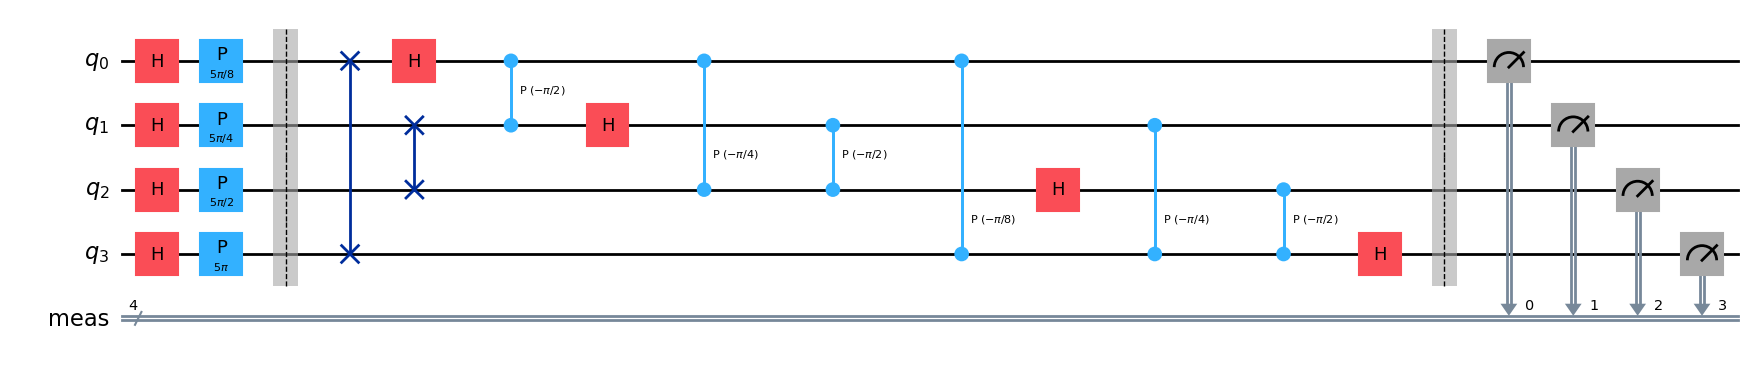

In [ ]:
number = 5

qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)

for qubit in range(nqubits):
    qc.p(number*pi/2**(nqubits-1-qubit),qubit)

qc.barrier()

qft_dagger(qc,nqubits)

# qc.save_statevector()
qc.measure_all()

qc.draw('mpl')

'#Simulate'

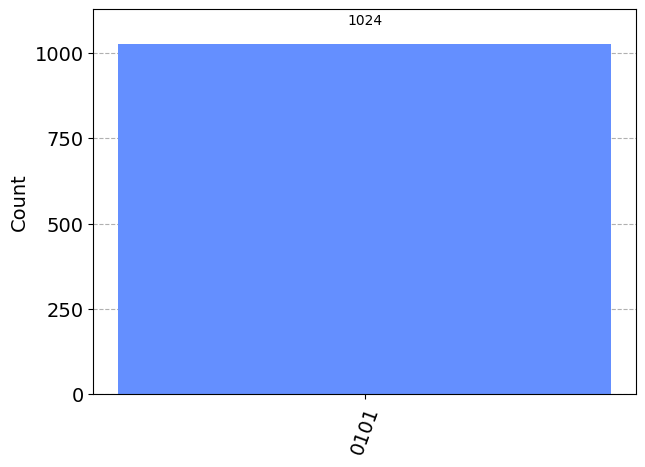

In [ ]:
'''#Simulate'''
decomposed_circ = qc.decompose()
job_sim = QasmSim.run(decomposed_circ, shots=1024)
counts = job_sim.result().get_counts()
plot_histogram(counts)

In [ ]:
print('Most frequent answer=' , 0b0101)
print(int('0b0101',2))

Most frequent answer= 5
5


Success.

We get the number 5 that we encoded in phase space by applying the inverse QFT.

## Bit-(QFT)-Phase-(InvQFT)-Bit

We can now also encode a bit into the phase space with the QFT then back to the bit space with the inverse QFT.

First, the same number '5' encoded in bits

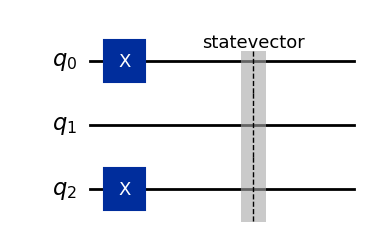

In [ ]:
qc = QuantumCircuit(3)

# Want to get state 5
qc.x(0)
qc.x(2)

qc.save_statevector()

qc.draw('mpl')

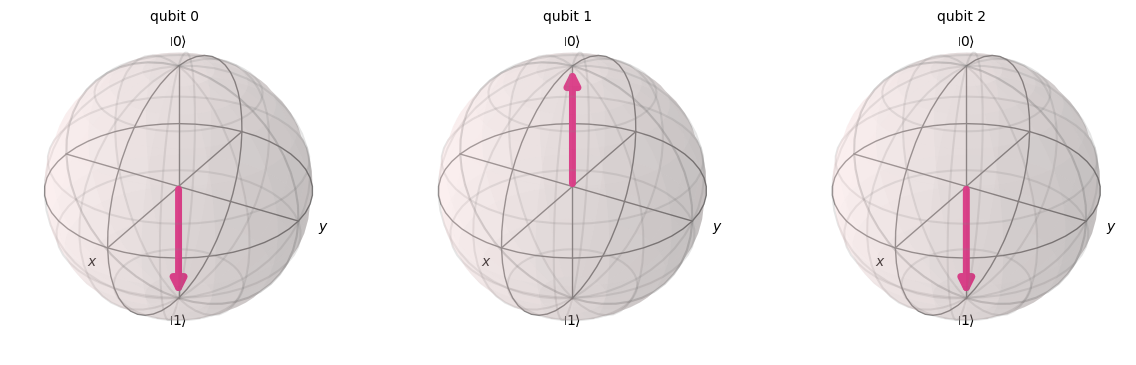

In [ ]:
#Simulate
job_sim = QasmSim.run(qc, shots=1)
statevector = job_sim.result().get_statevector(qc)
plot_bloch_multivector(statevector)

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

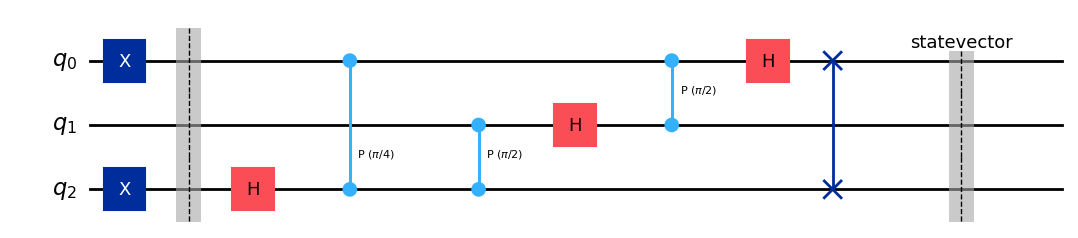

In [ ]:
qc = QuantumCircuit(3)

# Want to get state 5
qc.x(0)
qc.x(2)

qc.barrier()

qft(qc,3)

qc.save_statevector()

qc.draw('mpl')

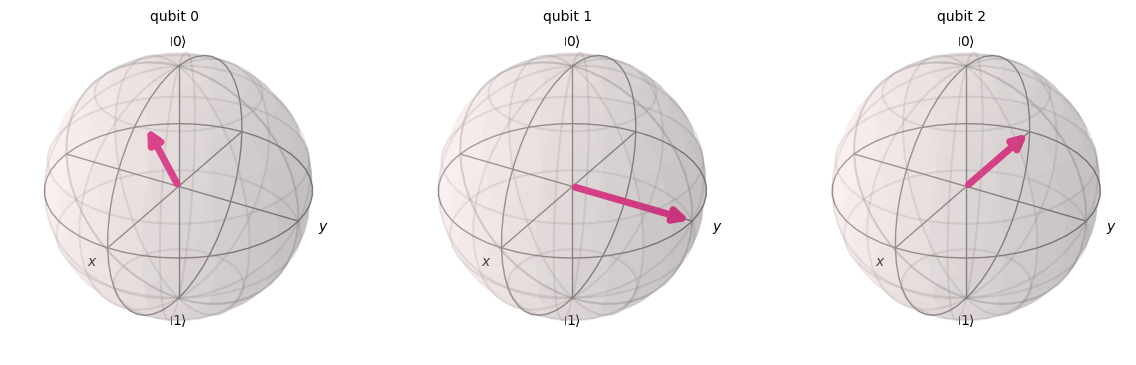

In [ ]:
#Simulate
job_sim = QasmSim.run(qc, shots=1)
statevector = job_sim.result().get_statevector(qc)
plot_bloch_multivector(statevector)

# Breaking down the QFT

The Quantum Fourier Transform is simply a means to encode the state space information of the qubit register along the Z basis into the phase space of the qubits within the X Y plane of the Bloch sphere.


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

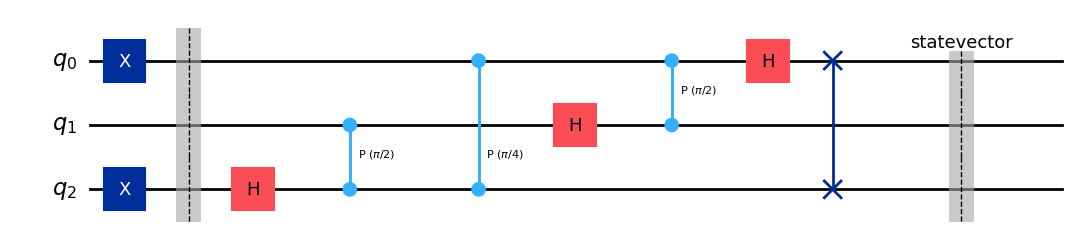

In [ ]:
qc = QuantumCircuit(3)

# Encode the state '5'
qc.x(0)
qc.x(2)

qc.barrier()

#Start at the last qubit and work your way back up

qc.h(2)
qc.cp(pi/2, 1, 2) # half pi phase gate qubits 1 - 2
qc.cp(pi/4, 0, 2) # quarter pi phase gate qubits 0 - 2

qc.h(1)
qc.cp(pi/2, 0, 1) # half pi phase gate qubits 0 - 1
qc.h(0)

#QFT has so far flipped the register , so we must flip it back with a swap gate
qc.swap(0,2)

qc.save_statevector()

qc.draw('mpl')

Qubit 2:
1. Starts in |0⟩ then the X gate flips it to |1⟩
1. Hadamard transforms |1⟩ to |-⟩
1. Control phase gate with q1 does nothing
1. Control phase gate with q0 rotates by π/4

Qubit 1:

1. Starts in |0⟩
1. Hadamard transforms it from |0⟩ to |+⟩\
1. Control phase gate with q0 rotates π/2

Qubit 0:

1. Starts in |0⟩ then the X gate flips it to |1⟩
1. Hadamard transforms |1⟩ to |-⟩

Swap:

1. Swap of qubit 0 and qubit 2





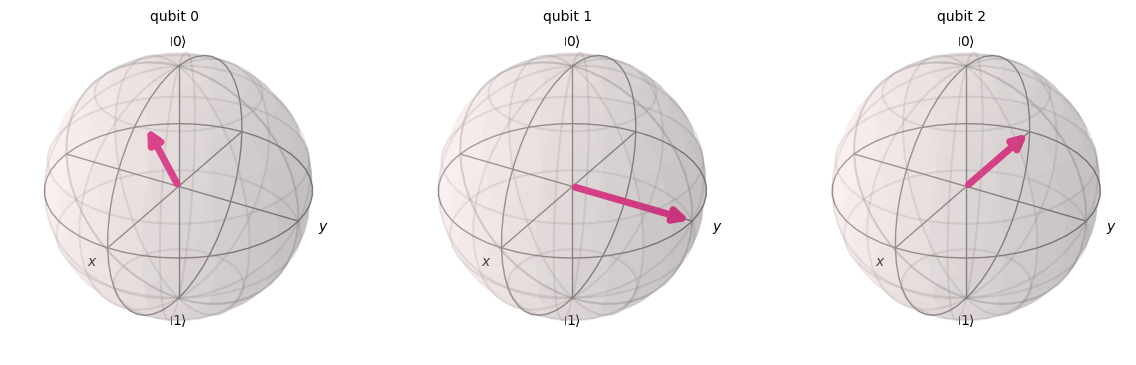

In [ ]:
#Simulate
job_sim = QasmSim.run(qc, shots=1)
statevector = job_sim.result().get_statevector(qc)
plot_bloch_multivector(statevector)

* We can see that qubit 0 is in the state we left qubit 2 in. Rotated from |-⟩ by a 'quarter' pi turn (π/4) which is only an eighth turn around the 2π Bloch sphere.

* Qubit 1 is as we left it started in |+⟩ and π/2 turn about the Z axis

* Qubit 2 is how we left qubit 0, in the |-⟩ state.

----

If we look back at the encoding for the Fourier state 5 we see that:

* The $5π/4$ turn for qubit 0 was equivalent to the π/4 turn from the |-⟩ state.

*  $5π/2$ is equivalent to a π/2 turn from |+⟩ for qubit 1

*  $5π$ turns from |+⟩ is equivalent to being in the |-⟩ state as it is 5 'pi' pulses where the first four just flip the state to and from |+⟩ and the last leaves it in |-⟩.



CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

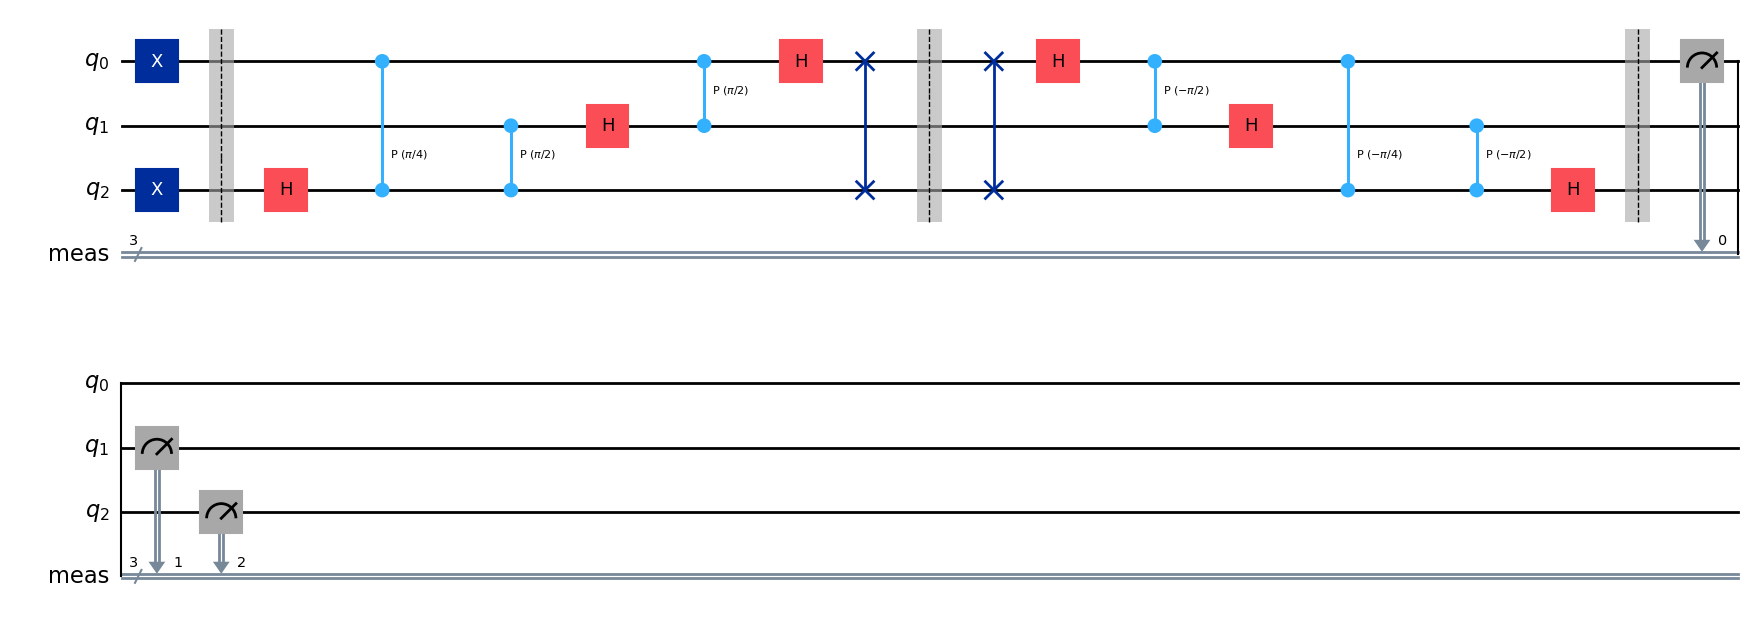

In [ ]:
qc = QuantumCircuit(3)

# Want to get state 5
qc.x(0)
qc.x(2)

qc.barrier()

qft(qc,3)

qc.barrier()

qft_dagger(qc,3)

qc.measure_all()
qc.draw('mpl')

'#Simulate'

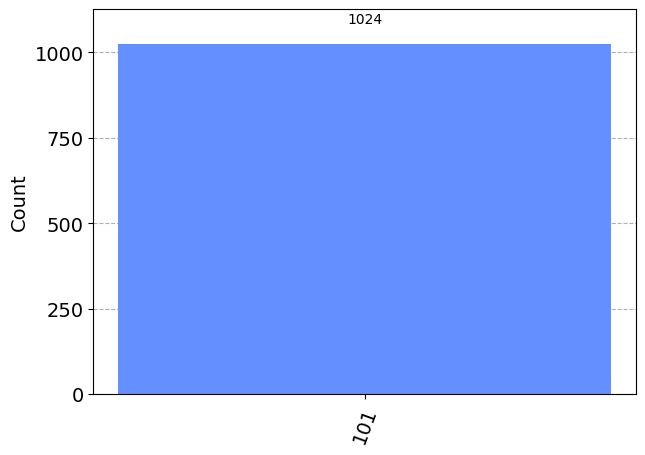

101
5


In [ ]:
'''#Simulate'''
decomposed_circ = qc.decompose()
job_sim = QasmSim.run(decomposed_circ, shots=1024)
counts = job_sim.result().get_counts()
plot_histogram(counts)

frequent = counts.most_frequent()
print(frequent)
print(int(frequent,2))

## Generalized QFT

In [ ]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

Setup a larger example

11111
31
5


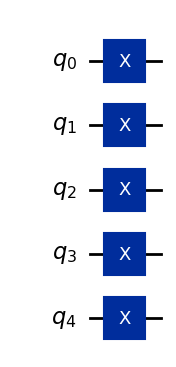

In [ ]:
a = 2**5-1
binarystring = format(a,"b")
print(binarystring)
print(int(binarystring,2))

#number of qubits required to encode 's'
n = len(binarystring)
print(n)

qc = QuantumCircuit(n)

binarystring_rev = binarystring[::-1] # reverse 's' to fit qiskit's qubit ordering

for q in range(n):
    if binarystring_rev[q] == '0':
        #If zero just pass the qubit through
        qc.i(q)
    else:
        #If 1 then add X gate
        qc.x(q)

qc.draw('mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4)), clbits=())

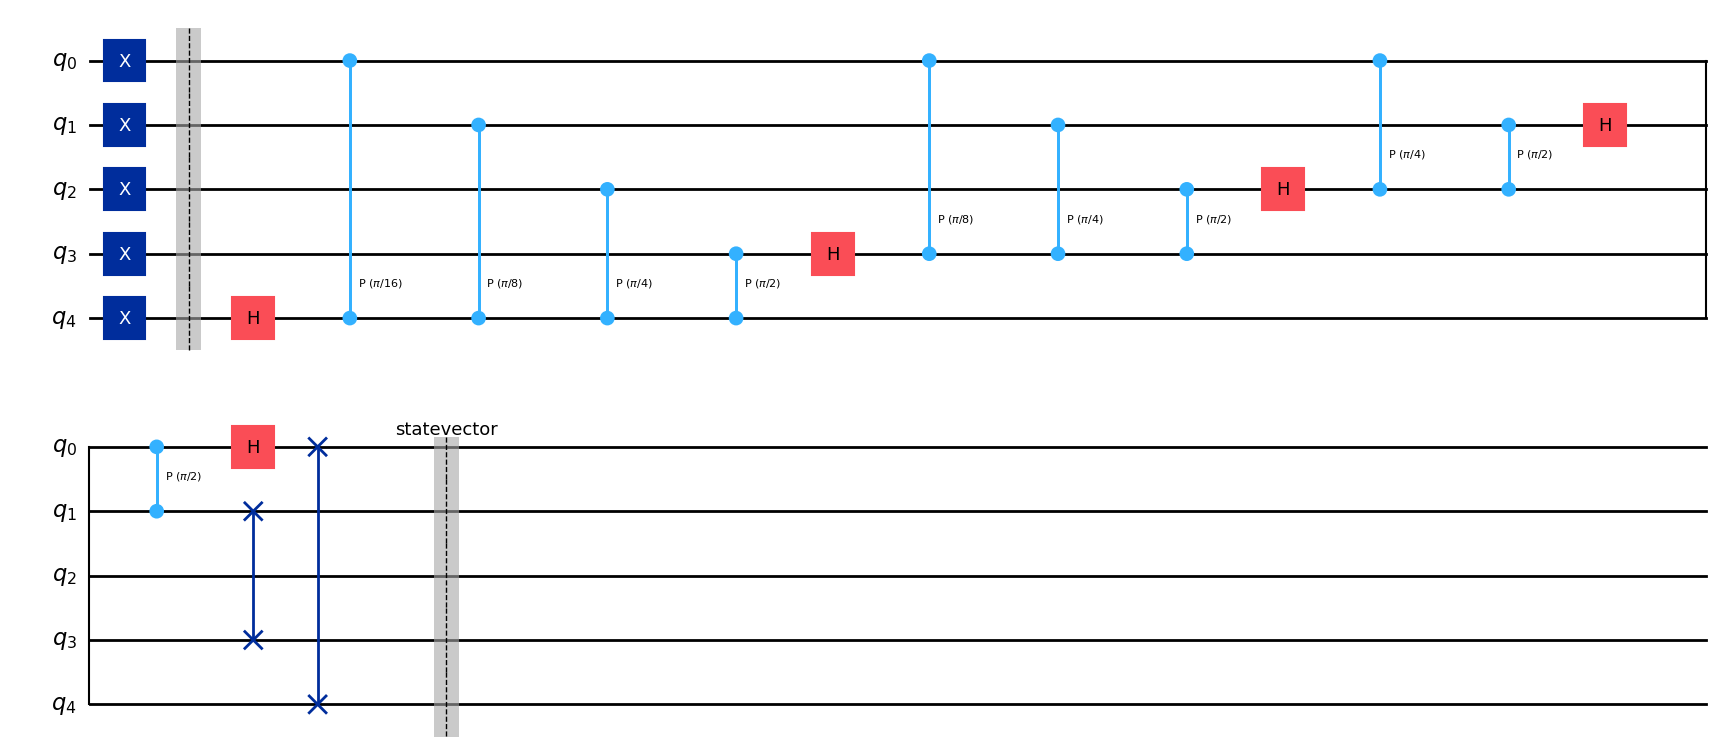

In [ ]:
qc = QuantumCircuit(n)

binarystring_rev = binarystring[::-1] # reverse s to fit qiskit's qubit ordering

for q in range(n):
    if binarystring_rev[q] == '0':
        #If zero just pass the qubit through
        qc.i(q)
    else:
        #If 1 then add X gate
        qc.x(q)

qc.barrier()

qft(qc,n)

qc.save_statevector()

qc.draw('mpl')

'Simulate Statevector'

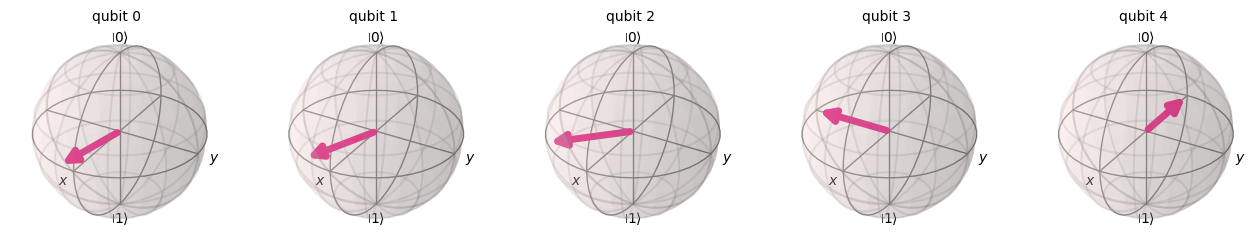

In [ ]:
'''Simulate Statevector'''
job_sim = QasmSim.run(qc, shots=1)
statevector = job_sim.result().get_statevector(qc)
plot_bloch_multivector(statevector)

#Quantum Phase estimation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator  U  , the algorithm estimates  θ  in  $U|ψ⟩=e^{2πiθ}|ψ⟩$ . Where  |ψ⟩  is an eigenvector and  $ e^{2πiθ} $  is the corresponding eigenvalue. Since  U  is unitary, all of its eigenvalues have a norm of 1.

Another way to think about it is that we're finally using Phase kickback for phase!

-----

To see this let us set up the quantum circuit.

We will use four qubits:

*  qubits 0, 1, 2 as counting qubits
 * Initialize the counting qubits in |+⟩

* qubit 3 as the eigenstate of the unitary operator.
 * Initialize qubit 3 in |1⟩




CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

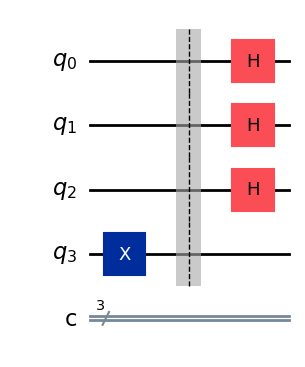

In [ ]:
qpe = QuantumCircuit(4, 3)

qpe.x(3)

qpe.barrier()

for qubit in range(3):
    qpe.h(qubit)

qpe.draw('mpl')

Next, apply phase gates to encode a specified phase angle (1/8) into the counting qubit register phase.

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

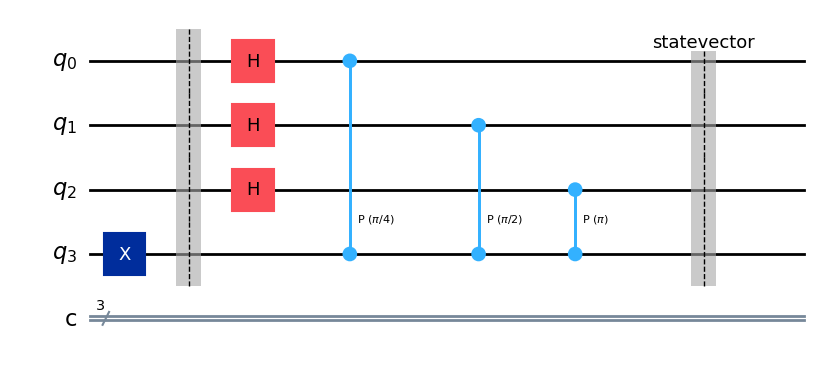

In [ ]:
phase_angle = 1/8

qpe = QuantumCircuit(4, 3)

qpe.x(3)

qpe.barrier()

for qubit in range(3):
    qpe.h(qubit)

for counting_qubit in range(3):
  qpe.cp( 2*pi*phase_angle*2**(counting_qubit), counting_qubit, 3)

qpe.save_statevector()

qpe.draw('mpl')

q_0 phase $= 2 \pi * 1 *1/8$

q_1 phase $= 2 \pi *2*1/8$

q_2 phase $= 2 \pi * 4*1/8$


'Simulate Statevector'

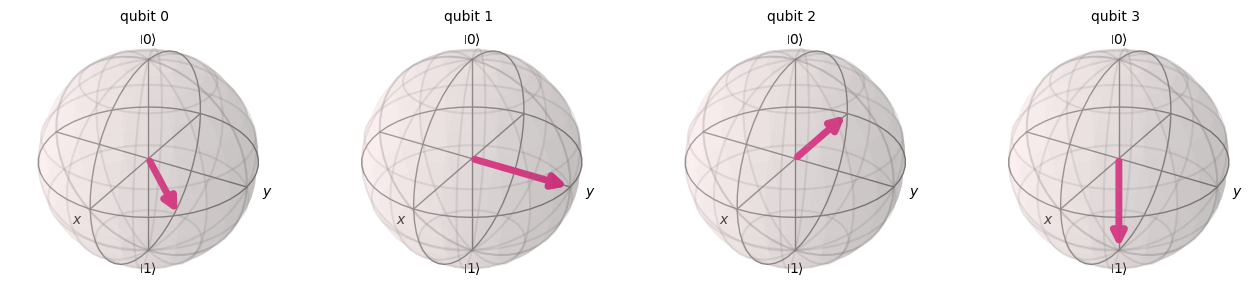

In [ ]:
'''Simulate Statevector'''
job_sim = QasmSim.run(qpe, shots=1)
plot_bloch_multivector(job_sim.result().get_statevector())

Next apply the Inverse Quantum Fourier Transform to bring it back from the X/Y phase basis to the Z (state) basis.

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

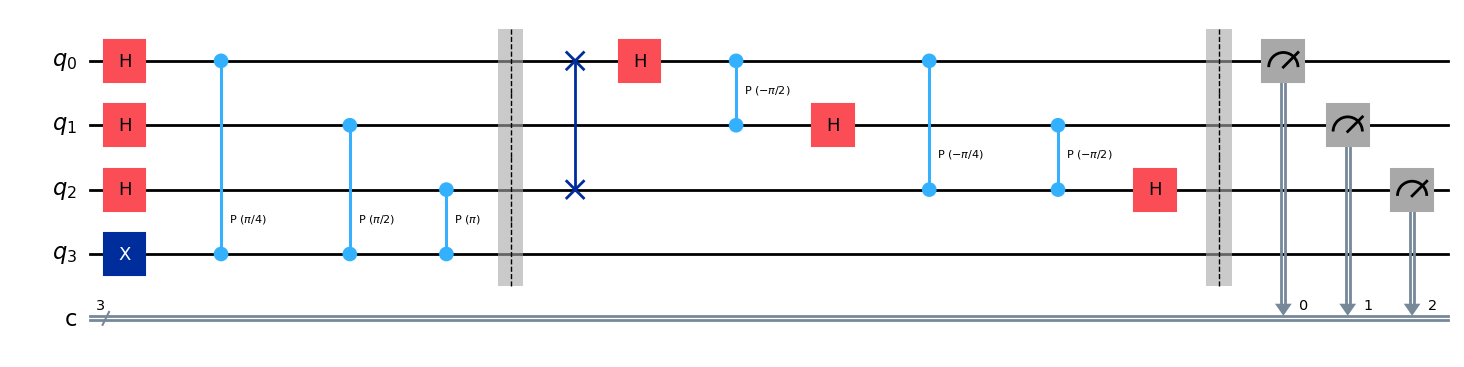

In [ ]:
def qft_dagger(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

qpe = QuantumCircuit(4, 3)
qpe.x(3)
for qubit in range(3):
    qpe.h(qubit)

for counting_qubit in range(3):
  qpe.cp( 2*pi*phase_angle*2**(counting_qubit), counting_qubit, 3)

qpe.barrier()

qft_dagger(qpe, 3)

qpe.barrier()

for n in range(3):
    qpe.measure(n,n)

qpe.draw('mpl')

'#Simulate'

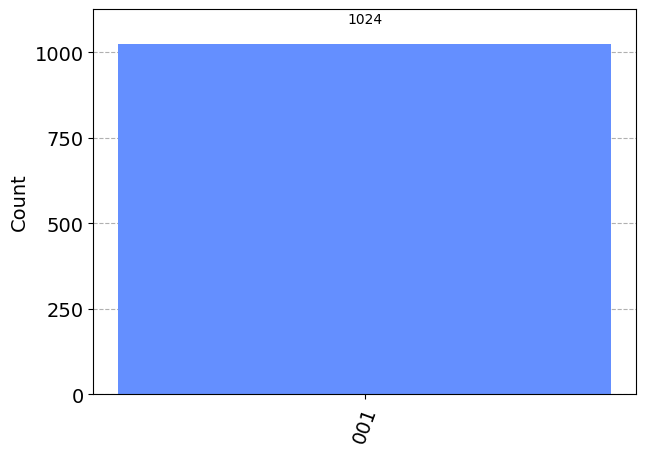

001
1


In [ ]:
'''#Simulate'''
job_sim = QasmSim.run(qpe, shots=1024)
counts = job_sim.result().get_counts()
plot_histogram(counts)

frequent = counts.most_frequent()
print(frequent)
print(int(frequent,2))

We have the counting value 1 (001 in binary).

The rotation angle basis of a 3 qubit register is:
$1/2^3 = 1/8$

So our value '1' times that rotation basis is:
$1*1/(2^3) = 1/8$

Which is the angle we had originally encoded.

___

## Encode the phase angle $1/3$

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())

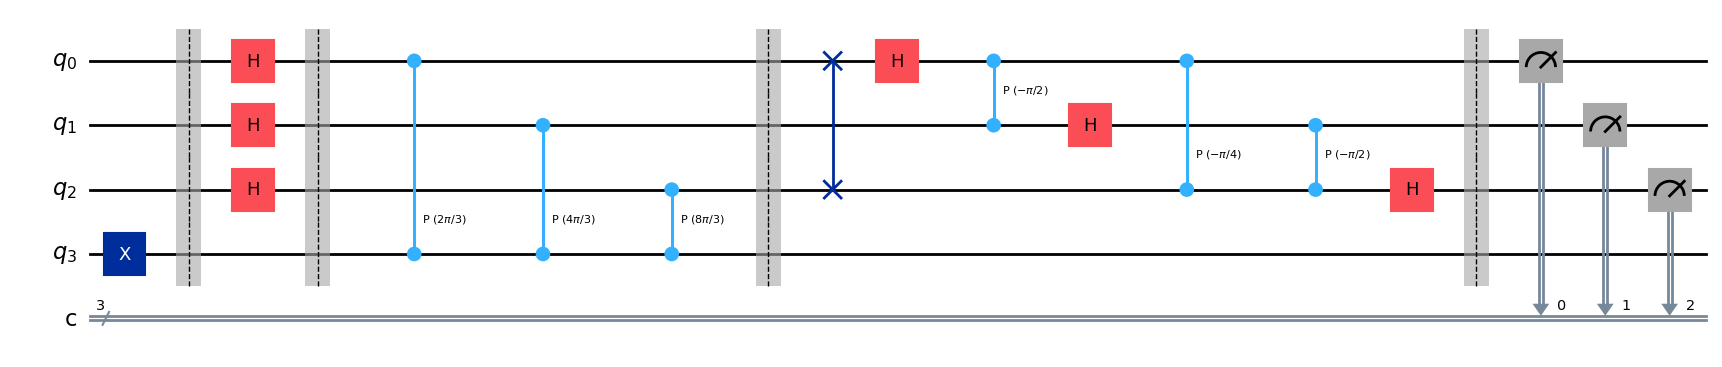

In [ ]:
phase_angle = 1/3

# Create and set up circuit
qpe = QuantumCircuit(4, 3)

# Prepare our eigenstate |psi>:
qpe.x(3)

qpe.barrier()

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe.h(qubit)

qpe.barrier()

# Do the controlled-U operations:
for counting_qubit in range(3):
  qpe.cp( 2*pi*phase_angle*2**(counting_qubit), counting_qubit, 3)

qpe.barrier()

# Do the inverse QFT:
qft_dagger(qpe, 3)

qpe.barrier()

for n in range(3):
    qpe.measure(n,n)

qpe.draw('mpl')

'#Simulate'

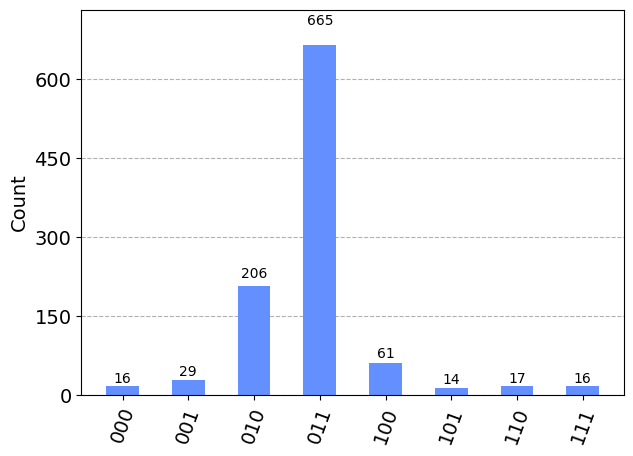

In [ ]:
'''#Simulate'''
job_sim = QasmSim.run(qpe, shots=1024)
counts = job_sim.result().get_counts()
plot_histogram(counts)

In [ ]:
from fractions import Fraction

frequent = counts.most_frequent()
print('Most Frequent bit string=',frequent)
print(int(frequent,2))
print(int(frequent,2)/2**3)
print(Fraction(int(frequent,2)/2**3))

Most Frequent bit string= 011
3
0.375
3/8


The most frequent answer is 011 which is 3 and represents the angle
$3/(2^3) = 0.375= 3/8$

We actually encoded 1/3...

However, we see that the second most frequent answer is
$010 = 2$

$2/8 = 0.25 = 1/4$

and if we average them weighted by their amplitudes:



In [ ]:
3/8*(719/1024)+1/4*(173/1024)+5/8*(41/1024)

0.33056640625

We get a little closer to the value we expect.

----

## More precision with more qubits

Further, if we add more qubits we get more precision

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit(QuantumRegister(6, 'q'), 5)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit(QuantumRegister(6, 'q'), 5)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit(QuantumRegister(6, 'q'), 5)), clbits=())

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit(QuantumRegister(6, 'q'), 5)), clbits=())

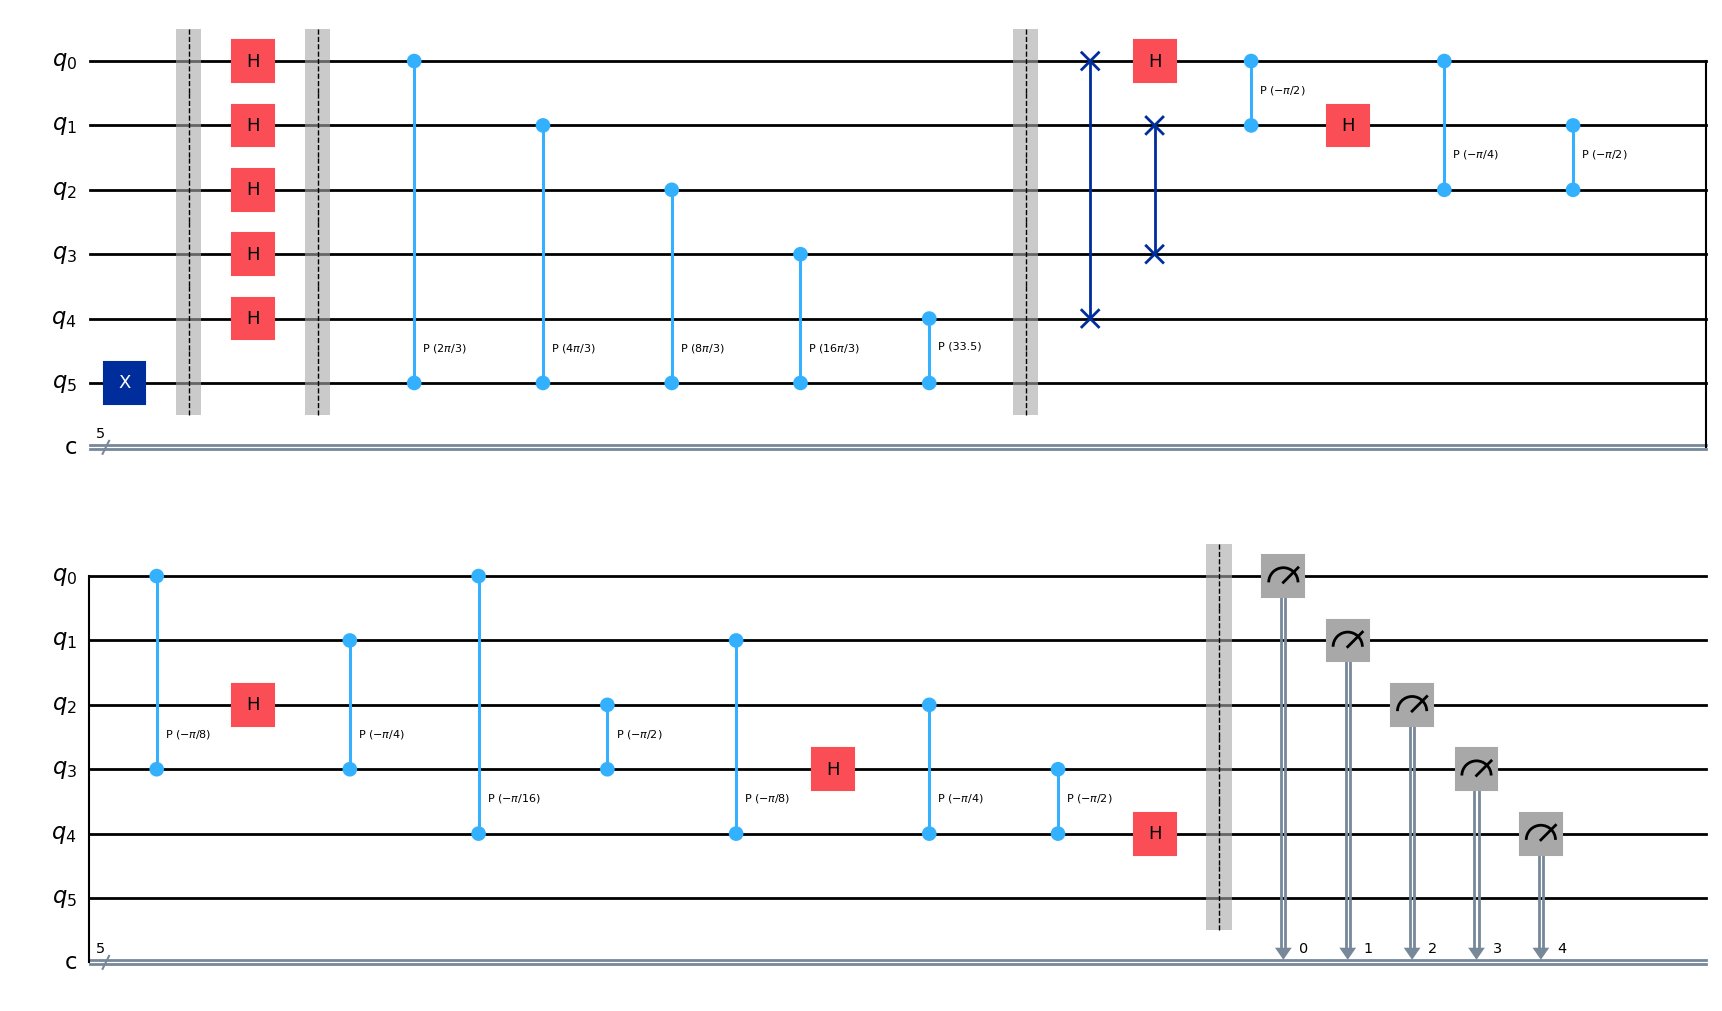

In [ ]:
phase_angle = 1/3

nqubits = 5

# Create and set up circuit
qpe = QuantumCircuit(nqubits+1, nqubits)

# Prepare our eigenstate |psi>:
qpe.x(nqubits)

qpe.barrier()

# Apply H-Gates to counting qubits:
for qubit in range(nqubits):
    qpe.h(qubit)

qpe.barrier()

# Do the controlled-U operations:
for counting_qubit in range(nqubits):
  qpe.cp( 2*pi*phase_angle*2**(counting_qubit), counting_qubit, nqubits)

qpe.barrier()

# Do the inverse QFT:
qft_dagger(qpe, nqubits)

qpe.barrier()

for n in range(nqubits):
    qpe.measure(n,n)

qpe.draw('mpl')

'#Simulate'

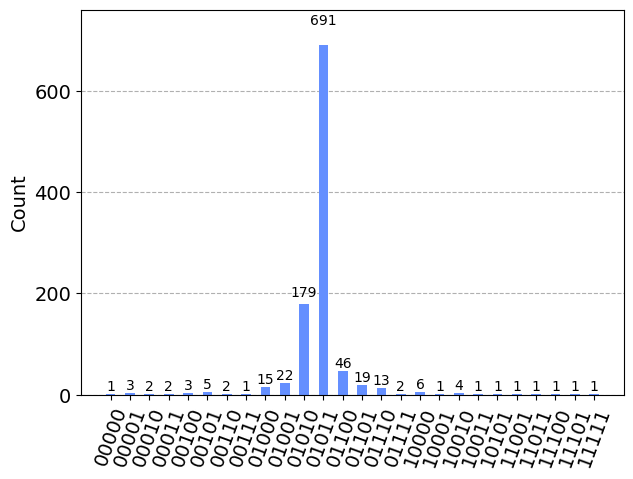

In [ ]:
'''#Simulate'''
job_sim = QasmSim.run(qpe, shots=1024)
counts = job_sim.result().get_counts()
plot_histogram(counts)

In [ ]:
from fractions import Fraction

nqubits = 5
print('N qubits in register = ',nqubits)

frequent = counts.most_frequent()
print('Most Frequent bit string=',frequent)
print(int(frequent,2)/2**nqubits)
print(Fraction(int(frequent,2)/2**nqubits))

N qubits in register =  5
Most Frequent bit string= 01011
0.34375
11/32


##End of Quantum Phase Estimation/Quantum Fourier Transform Section

# RSA encryption using public keys
RSA encryption is based on the difficulty of factoring large numbers that are the product of prime numbers.

The mathematical root is based on the observation that with integers e, d, and n:

$(m^e)^d = m ( \text{mod } n)$

That is, modular exponentiation for all integers m to the power 'e' and 'd' is equal to m (mod n).

> https://en.wikipedia.org/wiki/Modular_exponentiation

Therefore if we want to encrypt 'm' we exponentiate by a number 'e'.

**e can be public!**

Then upon exponentiation by 'd' we recover m!
[(mod n) of course]

How is this possible? And how to get 'e' and 'd'?


In [ ]:
# Secret primes are used as seeds to generate the public key
p, q = 5, 11

# Factorization is difficult so it is safe to share n publicly without revealing
# p and q
n_public = p * q

We require the ability to receive messages from a sender without any prior exchanging of secret information. To achieve this we use our primes to generate, and then publicize, a public key made up of two numbers $(e, n)$.

In the scheme laid out by RSA the encryption index , $e$ can be any number less than $n$ so long as it is coprime with:

## $\phi$ :  Euler's totient function
$\phi =  (p-1)(q-1)$

>Requiring that:  gcd$( ϕ, e) = 1$

So we randomly pick a number for 'e'.

But then verify that it is co-prime with $ϕ$ by checking that it's greatest common denominator is zero.

> https://www.geeksforgeeks.org/euclidean-algorithms-basic-and-extended/




Start by choosing two 'secret' prime numbers

$p=5$

$q=11$

Now we can go through the encryption and see how it works, including decrypting a secret message encrypted sent to us.

The first part of our Public Key is 'n':

$n =  p*q$

We can see now that our original expression is:

$(m^e)^d = m ( \text{mod } p \cdot q)$

Which will be true if:

$e \cdot d ≡ 1 ( \text{mod } p \cdot q)$


--------

To check if:

$m^{ed} ( \text{mod } p \cdot q) = m ( \text{mod } p \cdot q)$

it is equivalent to check that they are congruent to mod p and mod q **separately**

$m^{ed} ( \text{mod } p ) = m ( \text{mod } p)$

$m^{ed} = m^{ed-1}m = m^{h(p-1)}m = (m^{p-1})^h m = ? $

> **Fermat's little theorem:**

> If p is prime, then $(a^p - a)$ is a multiple of p, meaning:

> $a^p ( \text{mod } p ) = a ( \text{mod } p )$

> if we divide by 'a' then:

> $a^{p-1}  ( \text{mod } p ) = 1$

Therefore:

$(m^{p-1})^h \cdot m  ( \text{mod } p ) = (1)^h \cdot  m ( \text{mod } p )  $

And so

$m^{ed} ( \text{mod } p ) = m ( \text{mod } p)$

https://en.wikipedia.org/wiki/Fermat%27s_little_theorem



References:
* https://en.wikipedia.org/wiki/RSA_(cryptosystem)
* https://thatsmaths.com/2016/08/11/a-toy-example-of-rsa-encryption/ )

In [ ]:
# Choose a Public Key (e, n) used to encrypt the message
e_public = 7

# "Totient function" used to generate encryption keys
phi = (p-1)*(q-1)

# Ensure the encryption index is coprime with our totient function by checking
# The greatest common divisor is 1 (they have no other shared factors)
def gcd(a, b):
  if (a == 0):
    return b
  return gcd(b % a, a)

if gcd(e_public, phi) == 1:
  print('e=',e_public,' is co-prime with phi=',phi)
else:
  print('Common demoninator = ' , phi/gcd(e_public, phi))
  print('e=',e_public,' is NOT co-prime with phi=',phi)
  assert gcd(e_public, phi) == 1

print ('\nPublic key: n=', n_public, ', e=', e_public)

e= 7  is co-prime with phi= 40

Public key: n= 55 , e= 7


## Encryption Cipher
To calculate the Cipher message, $C$, the sender uses the public key values for e and n :

$C = P^e (\text{ mod }n )$

raising their plain text message, P,  to the power 'e' and taking the modulo n.

In order to apply this method, the message needs to be broken down into blocks smaller than $n$ (which in this case is 55).

Since there are only 26 letters in the alphabet we just convert the message into a string of numbers by assigning each letter a number value based on it's position in the alphabet.

In [ ]:
message = 'secret'
print('Plain-text:', message)

def encrypt(message, e, n):
  encoded = [ord(letter) - 96 for letter in message]
  print('\nP (plain) encoding in unicode = ',encoded)

  ciphertext = [(letter ** e) % n for letter in encoded]
  print('\nC = P^e mod n (cipher) in unicode = ',ciphertext)

  encryptedmessage = ''.join([chr(letter + 96) for letter in ciphertext])
  return str(encryptedmessage)

encryptedmessage = encrypt(message, e_public, n_public)
print('\nCipher-text:', encryptedmessage)

Plain-text: secret

P (plain) encoding in unicode =  [19, 5, 3, 18, 5, 20]

C = P^e mod n (cipher) in unicode =  [24, 25, 42, 17, 25, 15]

Cipher-text: xyqyo


## Decrypting the message
We, the receiver, then apply the decryption scheme:

$D = C^d (\text{ mod }n)$

Remember we just calculated C:

$C = P^e (\text{ mod }n )$

so

$D = (P^e)^d (\text{ mod }n) $

And because



In [ ]:
def decrypt(encryptedmessage, d, n):
  encryptedmessage = [ord(letter) - 96 for letter in encryptedmessage]
  print('\nC (cipher) encoding in unicode = ',encryptedmessage)

  plaintext = [(letter ** d) % n for letter in encryptedmessage]
  print('\nD (decrypted) encoding in unicode = ',encoded)

  message = ''.join([chr(letter + 96) for letter in plaintext])
  return message

# encryptedmessage = encrypt(message, e_public, n_public)
# print('\nCipher-text:', encryptedmessage)
# decryptedmessage = decrypt(encryptedmessage, d_private, n_public)
# print('Decrypted message:', decryptedmessage)

oops we didn't define the private key 'd' yet!

The sender didn't know it but we can constuct it.

----

## d , private key

Our decrypted message D will be equal to their original plain text message P if we pick 'd' such that:

 $ e \times d \equiv 1 \text{ (mod } \phi$)

 and

 $ 0 \leq d \leq n $

To set this up, the decryption index $d$ is constructed from our secret prime using Euler's extended algorithm.

The EED calculates not just the gcd but also x and y such that:
$ ax+by=gcdEE(a,b)$

If we set $a=e$ and  $b=φ(n)$

Then we already know gcd$(e,φ(n))=1$, by definition because we checked when we picked 'e'

>They need to be coprime for the inverse to exist

Therefore:

$e \cdot x + ϕ(n) \cdot y = 1$

Taking the modulo of ϕ, removes the factor $ϕ(n) \cdot y$ which mod $\phi$ is just zero, so:

$e \cdot x = 1 $ $($mod$(ϕ(n))$

Since we were looking for:

 $ e \cdot d \equiv 1 \text{ mod } \phi$

 We see that $x = d$


 ----

So by solving gcdEE$(ϕ, e_{public})$ we will find integer coefficients s and t such that:

$as + bt = gcdEE(a, b) $

$ϕ \times s + e_{public} \times t = gcdEE(ϕ, e_{public}) $

Where t is now the private key 'd'!

> https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm

In [ ]:
print(phi)
print(e_public)

40
7


In [ ]:
def gcdExtended(a, b):

    # Base Case
    if a == 0 :
        return b, 0, 1

    gcd, x1, y1 = gcdExtended(b%a, a)

    # Update x and y using results of recursive
    # call
    x = y1 - (b//a) * x1
    y = x1

    return gcd, x, y

print('phi=',phi)
print('e_public=',e_public)

gcdEE, s, t = gcdExtended(phi, e_public)

d_private = t

d_private %= phi

print('\ngcdEE=',gcdEE)
print('s =',s)
print('t =',t)
print('d = t (mod phi)=', d_private)
print('\nCheck if phi*s+e_public*t=1 ?', phi*s+e_public*t==1)

print ('\nPrivate decryption key, d =', d_private)

phi= 40
e_public= 7

gcdEE= 1
s = 3
t = -17
d = t (mod phi)= 23

Check if phi*s+e_public*t=1 ? True

Private decryption key, d = 23


This is our secret key, it is important not to share this with anyone as it can be used to decrypt any messages that are encrypted using our public key.

In [ ]:
def decrypt(encryptedmessage, d, n):
  encryptedmessage = [ord(letter) - 96 for letter in encryptedmessage]

  plaintext = [(letter ** d) % n for letter in encryptedmessage]
  print('\nD = C^d (mod n), decrypted encoding in unicode = ',plaintext)

  message = ''.join([chr(letter + 96) for letter in plaintext])
  return message

encryptedmessage = encrypt(message, e_public, n_public)

print('\nEncrypted message:', encryptedmessage)

decryptedmessage = decrypt(encryptedmessage, d_private, n_public)
print('\nDecrypted message:', decryptedmessage)


P (plain) encoding in unicode =  [19, 5, 3, 18, 5, 20]

C = P^e mod n (cipher) in unicode =  [24, 25, 42, 17, 25, 15]

Encrypted message: xyqyo

D = C^d (mod n), decrypted encoding in unicode =  [19, 5, 3, 18, 5, 20]

Decrypted message: secret


## Vulnerability to Attack
Imagine a hacker is able to steal the encrypted message in transit

In [ ]:
stolenmessage = encryptedmessage

print('Stolen message:', stolenmessage)

Stolen message: xyqyo



The stolen message should be completely meaningless because the hacker does not know $d_{private}$ the private decryption key required to read the message.

The problem is that $n_{public}$ and $e_{public}$ are publicly available. We can use [SymPy](https://www.sympy.org/en/index.html) to factorize $n$, and find $p$ and $q$.

In [ ]:
from sympy.ntheory import factorint

a,b = factorint(n_public)
print ('Factors:', a, ',', b)

Factors: 5 , 11


Once we have these it is simple to calculate ϕ and then use the extended Euclidean algorithm to generate $d_{secret}$ the secret decryption key which will expose the secret message.

In [ ]:
phi_stolen = (a-1)*(b-1)
_, _, d_stolen = gcdExtended(phi_stolen, e_public)
d_stolen %= phi_stolen

exposedmessage = decrypt(stolenmessage, d_stolen, n_public)
print('Exposed message:', exposedmessage)


D = C^d (mod n), decrypted encoding in unicode =  [19, 5, 3, 18, 5, 20]
Exposed message: secret


## Safety in large numbers

However, the 'factorint' quickly bogs down for large numbers.

$55 \sim 2^6$ and $7 \sim 2^3$ so the encryption key requires only 9 bits to store. Actual keys use > 1,024 bits and so much larger chunks of information can be encoded together and securely encrypted.

Further, in this toy example each character will just be predictably substituted for another [substitution cipher](https://en.wikipedia.org/wiki/Substitution_cipher) and is susceptible to attacks such as [frequency analysis](https://en.wikipedia.org/wiki/Frequency_analysis).


In [ ]:
integer = 2**10 +1

print(integer)
print(factorint(integer))

1025
{5: 2, 41: 1}


'\nPlot Factor time vs. bit length of number\n'

<Figure size 1000x700 with 0 Axes>

Text(0.5, 1.0, 'Factor Time')

Text(0, 0.5, 'time [s]')

Text(0.5, 0, 'bit size number')

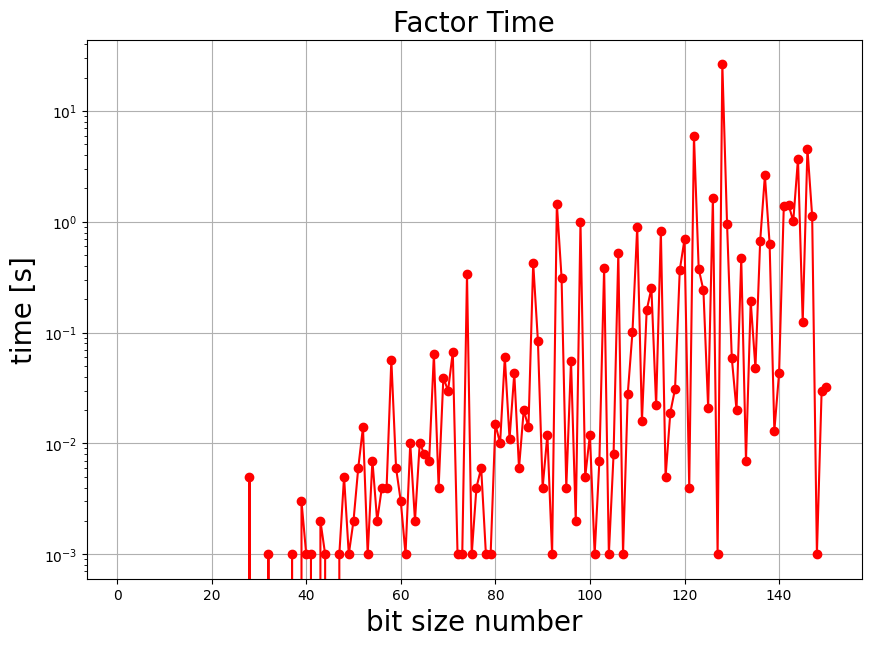

In [ ]:
min_exp = 1
max_exp = 150
step_exp = 1
elapsed_times = []

for exp in range(min_exp, max_exp+1,step_exp):


  integer = 2**exp +1

  start = time.time()

  factors = factorint(integer)

  elapsed_time = round(time.time() - start,3)
  elapsed_times.append(elapsed_time)
  # print("SOLVED: factored = " + str(integer) + " in " , elapsed_time, 'seconds')

'''
Plot Factor time vs. bit length of number
'''
figsize = 10
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()

plt.plot(range(min_exp, max_exp+1,step_exp), elapsed_times , 'o-r')

fs=20 #fontsize
plt.title('Factor Time', fontsize=fs)
ax.set_ylabel(r'time [s]', fontsize=fs);
ax.set_xlabel(r'bit size number', fontsize=fs);
plt.grid()
ax.set_yscale('log')


'\nPlot Factor time vs. bit length of number\n'

<Figure size 1000x700 with 0 Axes>

Text(0.5, 1.0, 'Factor Time vs. bit number (relative to age of universe)')

Text(0, 0.5, 'time [s]')

Text(0.5, 0, 'bit size of number')

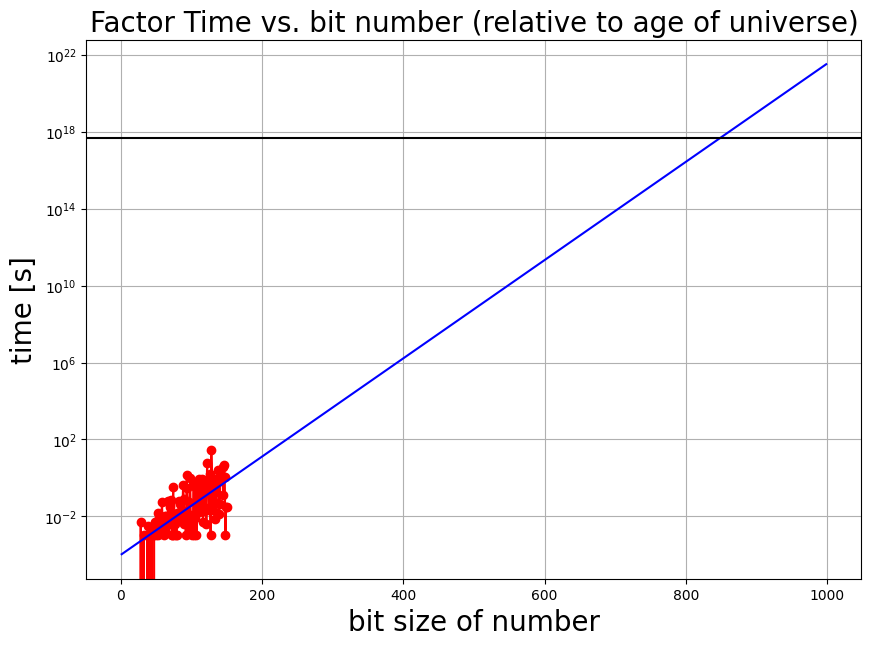

In [ ]:

'''
Plot Factor time vs. bit length of number
'''
figsize = 10
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()

plt.plot(range(min_exp, max_exp+1,step_exp), elapsed_times , 'o-r')

extrap_x = range(1, 1000,step_exp)
plt.plot(extrap_x, np.exp(np.array(extrap_x)/17)*1e-4 , '-b')
plt.axhline(y = 4.7e17, color = 'k', linestyle = '-')

fs=20 #fontsize
plt.title('Factor Time vs. bit number (relative to age of universe)', fontsize=fs)
ax.set_ylabel(r'time [s]', fontsize=fs);
ax.set_xlabel(r'bit size of number', fontsize=fs);
plt.grid()
ax.set_yscale('log')


In [ ]:
'''
350 'bits' takes a couple minutes to factor
'''
# exp = 350

integer = 2**exp +1

print(integer)
print(factorint(integer))

"\n350 'bits' takes a couple minutes to factor\n"

1427247692705959881058285969449495136382746625
{5: 3, 13: 1, 41: 1, 61: 1, 101: 1, 1201: 1, 1321: 1, 8101: 1, 63901: 1, 268501: 1, 13334701: 1, 1182468601: 1}


# Exercises
  1. Manually encode the angle 15/32 in the qubit fourier basis. How many qubits do you need to encode it?
  1. Use the inverse QFT to convert your encoded angle back to the Z basis.
  1. Send your lab partner an encoded message of your qubit and quantum algorithm for your final project using RSA. Have them calculate the correct keys for you. (include the code below).
  1. Try cracking the code with the classical factoring algorithm, how long does it take?
  1. Complete your groups 1 page proposal for your final project by Monday:

650 Algorithm Proposal:
* 1 page minimum
* Give an overview of how your quantum algorithm works:
 * What is the problem it is trying to solve?
 * What is the classical solution?
 * What is the quantum solution?
* Review how your qubit works.
 * What is your qubit made of?
 * How do you execute single qubit gates on your qubit?
 * How do you run two qubit gates on your qubit?
 * What limits your qubit? Coherence time? Gate fidelity?
 * What companies use your qubit?
* Error sources
 * What possible error sources limit your qubit and algorithm?
 * Can composite pulse sequences help?
 * What error levels would be needed for your algorithm to work?
* Presentation and Code
 * Break it down to the bare single qubit and two qubit gates
 * What example will you work out in your code to show how it works?
 * How will you breakdown the problem to show everyone how it works?
 * What visualization tools will you use to show what is happening?

  

In [ ]:
'''
Exercise 1
'''


'\nExercise 1\n'

In [ ]:
'''
Exercise 2
'''


'\nExercise 2\n'